Data preprocessing

In [2]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Load the dataset

data = pd.read_csv('dataset.csv')

# Display the first few rows of the dataset
data.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,id,news_url,title,tweet_ids
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...


In [3]:
# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower().strip()  # Normalize to lowercase and strip spaces
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Apply preprocessing to the 'title' column
data['cleaned_title'] = data['title'].apply(preprocess_text)

# Display the updated dataframe
data[['title', 'cleaned_title']].head()


,title,cleaned_title
0,BREAKING: First NFL Team Declares Bankruptcy O...,breaking first nfl team declares bankruptcy kn...
1,Court Orders Obama To Pay $400 Million In Rest...,court order obama pay 400 million restitution
2,UPDATE: Second Roy Moore Accuser Works For Mic...,update second roy moore accuser work michelle ...
3,Oscar Pistorius Attempts To Commit Suicide,oscar pistorius attempt commit suicide
4,Trump Votes For Death Penalty For Being Gay,trump vote death penalty gay


In [4]:
# Function to extract named entities from text
def extract_named_entities(text):
    doc = nlp(text)
    entities = {"ORG": 0, "GPE": 0, "PERSON": 0}
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_] += 1
    return entities

# Apply NER to the cleaned titles
data['ner_counts'] = data['cleaned_title'].apply(extract_named_entities)

# Expand the NER counts into separate columns
data['org_count'] = data['ner_counts'].apply(lambda x: x['ORG'])
data['gpe_count'] = data['ner_counts'].apply(lambda x: x['GPE'])
data['person_count'] = data['ner_counts'].apply(lambda x: x['PERSON'])

# Display the updated dataframe
data[['title', 'org_count', 'gpe_count', 'person_count']].head()


,title,org_count,gpe_count,person_count
0,BREAKING: First NFL Team Declares Bankruptcy O...,0,0,0
1,Court Orders Obama To Pay $400 Million In Rest...,0,0,0
2,UPDATE: Second Roy Moore Accuser Works For Mic...,0,0,2
3,Oscar Pistorius Attempts To Commit Suicide,1,0,0
4,Trump Votes For Death Penalty For Being Gay,0,0,0


In [5]:
# Add sentiment polarity as a feature
data['sentiment_polarity'] = data['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Add title length as a feature
data['title_length'] = data['cleaned_title'].apply(lambda x: len(x.split()))

# Display the dataset with new features
data[['title', 'sentiment_polarity', 'title_length']].head()


,title,sentiment_polarity,title_length
0,BREAKING: First NFL Team Declares Bankruptcy O...,0.250000,8
1,Court Orders Obama To Pay $400 Million In Rest...,0.000000,7
2,UPDATE: Second Roy Moore Accuser Works For Mic...,0.142857,9
3,Oscar Pistorius Attempts To Commit Suicide,0.000000,5
4,Trump Votes For Death Penalty For Being Gay,0.416667,5


In [6]:
# Select features and a mock target variable
features = ['org_count', 'gpe_count', 'person_count', 'sentiment_polarity', 'title_length']

# Mock engagement metric as the target (since no engagement metric is present)
# For demonstration, we will generate random values (replace with actual engagement data if available)
import numpy as np
data['engagement_metric'] = np.random.randint(50, 500, data.shape[0])

# Split the dataset into training and testing sets
X = data[features]
y = data['engagement_metric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 123.80290237990296


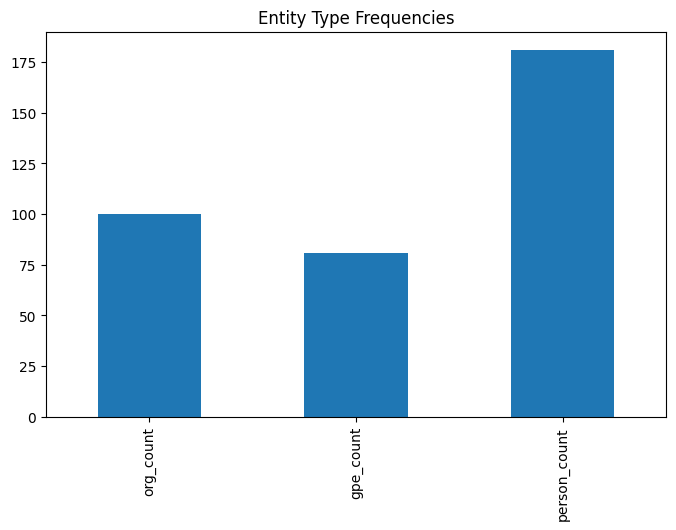

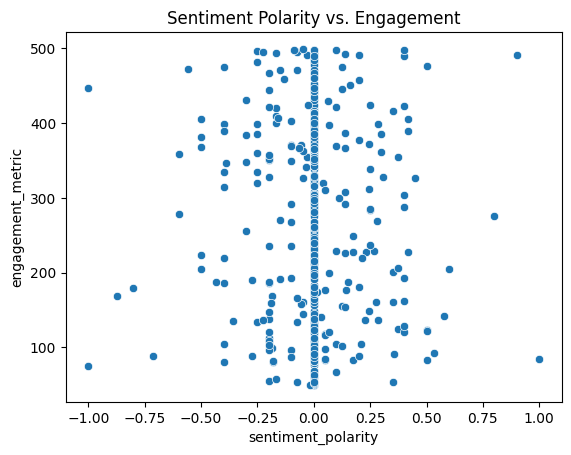

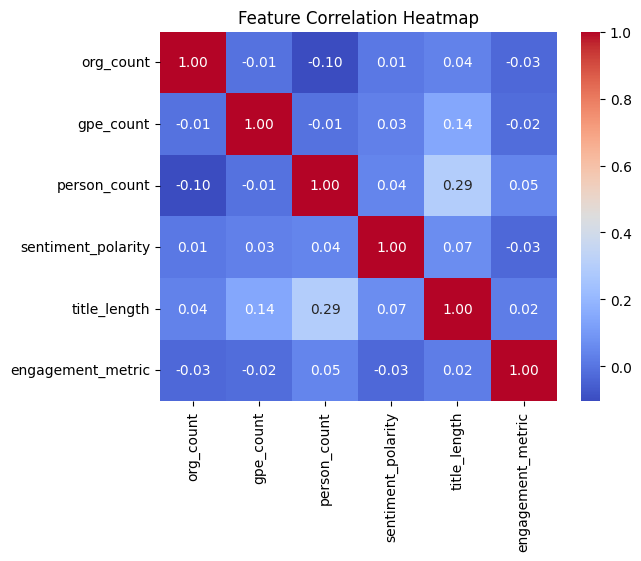

In [7]:
# Bar chart for entity frequencies
entity_counts = data[['org_count', 'gpe_count', 'person_count']].sum()
entity_counts.plot(kind='bar', title="Entity Type Frequencies", figsize=(8, 5))
plt.show()

# Scatter plot: Sentiment polarity vs. engagement
sns.scatterplot(data=data, x='sentiment_polarity', y='engagement_metric')
plt.title("Sentiment Polarity vs. Engagement")
plt.show()

# Heatmap: Correlation matrix
correlation_matrix = data[features + ['engagement_metric']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [8]:
# Save the processed dataset to a CSV file
data.to_csv('processed_dataset.csv', index=False)
print("Processed dataset saved to 'processed_dataset.csv'.")


Processed dataset saved to 'processed_dataset.csv'.
